In [204]:
# download temp mean data for Global 2m temps (GFS Ensemble 0.5 Degree Bias-Corrected)
# doc: at https://nomads.ncep.noaa.gov/
# this will take multiple minutes
import os
import requests
import time
from bs4 import BeautifulSoup
import pygrib
import numpy as np
from datetime import datetime, timedelta
import glob
# for use in calculating average weighted means
# use ellipsoid model for calculating average weighted means
import pyproj
import re

# if the 384h is not available the online data set is not complete (ge10pt.t12z.pgrb2a.0p50_bcf384 for example)
expected_max_tau = 384

# there is also another hardcoded URL below to download GEFS BC (0.5 deg) data
base_gefs_folder_url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/naefs/prod/'


# HARDCODED expected GEFS time steps (strings)
gefs_time_steps = ['003', '006', '009', '012', '015', '018', '021', '024', '027', '030', '033', '036', '039', '042', '045', '048', '051', '054', '057', '060', '063', '066', '069', '072', '075', '078', '081', '084', '087', '090', '093', '096', '099', '102', '105', '108', '111', '114', '117', '120', '123', '126', '129', '132', '135', '138', '141', '144', '147', '150', '153', '156', '159', '162', '165', '168', '171', '174', '177', '180', '183', '186', '189', '192', '198', '204', '210', '216', '222', '228', '234', '240', '246', '252', '258', '264', '270', '276', '282', '288', '294', '300', '306', '312', '318', '324', '330', '336', '342', '348', '354', '360', '366', '372', '378', '384']
gefs_init_times = ['00', '06', '12', '18']

# for comparison
cfsr_extrapolate_year = 2023
cfsr_filepath = '../cfsr_world_t2_day.json'
cfsr_folder = '../'
cfsr_url = 'https://climatereanalyzer.org/clim/t2_daily/json_cfsr/cfsr_world_t2_day.json'

# increase notebook width
from IPython.display import display, HTML
#display(HTML("<style>.container { width:'100%' !important; }</style>"))
display(HTML("<style>.container { width:'normal' !important; }</style>"))

In [205]:













#############################################################
######         DOWNLOAD NEW GEFS FORECASTS             ######
#############################################################






















In [206]:
def download_file(url, folder_path):
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'wb') as f:
        f.write(response.content)

def get_file_urls(base_url, t):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = []
    found_max_tau = False
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and not href.startswith('../') and href.startswith('geavg.t' + t + 'z.pgrb2a.0p50_bcf') and 'idx' not in href:
            if href.endswith(str(expected_max_tau)):
                found_max_tau = True
            urls.append(href)
    if found_max_tau:
        return urls
    else:
        return None

def get_folder_names(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and not href.startswith('../') and href.startswith('gefs.'):
            urls.append(href.rstrip("/"))
    return urls

def get_subfolder_names(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = []
    for link in soup.find_all('a'):
        href = link.get('href').rstrip("/")
        if href and not href.startswith('../') and href in gefs_init_times:
            urls.append(href)
    return urls

In [207]:
#### GET LIST OF LOCAL FOLDERS THAT HAVE COMPLETE FORECASTS (according to gefs_time_steps)
#### These are in the format of gefs.20230920_00  (that is, the gefs folder name online + '_' + time step subfolder name)
#folders = ["gefs.20230726", "gefs.20230727", "gefs.20230728", "gefs.20230729", "gefs.20230730", "gefs.20230731", "gefs.20230801", "gefs.20230802", "gefs.20230803", "gefs.20230804", "gefs.20230805", "gefs.20230805_12", "gefs.20230805_18", "gefs.20230806"]  # Add more folders if needed
# Get a list of all items in the current directory
items = os.listdir()
# Filter out only the folder names
unsorted_folders = [item for item in items if os.path.isdir(item)]
# Sort the folder names in alphabetical order
folders = sorted(unsorted_folders)

gefs_folder_list_existing = []
# Compute the weighted-area average 2m temps for each folder
for folder in folders:
    if 'gefs.' in folder:
        #gefs_folder_list_exiting.append()
        folder_path = os.path.join(".", folder)
        file_list = sorted(glob.glob(os.path.join(folder_path, "*")))
        gefs_folder_time_steps = sorted([re.findall(re.compile('.*bcf(\d\d\d)'), z)[0] for z in file_list if re.findall(re.compile('.*bcf(\d\d\d)'), z)])
        # assume the directory ONLY has the data and nothing else
        if gefs_time_steps == gefs_folder_time_steps:
            # looks to have complete folder data
            # only show folders that are complete (otherwise, re-download whole folder)
            gefs_folder_list_existing.append(os.path.basename(folder))

In [208]:
online_gefs_folders = get_folder_names(base_gefs_folder_url)
local_folder_names_to_urls = []
online_gefs_folder_names_with_times_to_nomads_urls = {}
for online_gefs_folder_name in online_gefs_folders:
    online_subfolder_names = get_subfolder_names(f"{base_gefs_folder_url}/{online_gefs_folder_name}")
    for subfolder_name in online_subfolder_names:
        online_to_local_folder_name = online_gefs_folder_name + "_" + subfolder_name
        
        if online_to_local_folder_name not in gefs_folder_list_existing:
            # get file urls (will be None if it is not complete (does not have file until max_tau))
            file_urls = get_file_urls(f"{base_gefs_folder_url}/{online_gefs_folder_name}/{subfolder_name}/pgrb2ap5_bc", subfolder_name)
            if not file_urls:
                time.sleep(2)
                continue
            print(online_to_local_folder_name)
            numfiles = len(file_urls)

            if not os.path.exists(online_to_local_folder_name):
                os.makedirs(online_to_local_folder_name)

            print(f"Downloading {numfiles} download files for GEFS, bias corrected, 2m ensemble mean temperatures")

            time.sleep(2)
            i = 0
            numfiles = len(file_urls)
            for file_url in file_urls:
                # HARDCODED URL FOR GEFS BC
                download_url = f"https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/{online_gefs_folder_name}/{subfolder_name}/pgrb2ap5_bc&file={file_url}&var_TMP=on&lev_2_m_above_ground=on"
                i += 1
                print(f" - Downloading {i} / {numfiles} : {download_url}")
                download_file(download_url, online_to_local_folder_name)
                time.sleep(2)  # Pause for 2 seconds between downloads

gefs.20231022_18
 - Downloading 1 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf003&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 2 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf006&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 3 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf009&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 4 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf012&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 5 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf015&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 6 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensb

 - Downloading 46 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf138&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 47 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf141&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 48 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf144&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 49 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf147&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 50 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf150&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 51 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/g

 - Downloading 91 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf354&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 92 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf360&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 93 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf366&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 94 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf372&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 95 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231022/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf378&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 96 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/g

In [209]:
# calculate averages for downloaded forecast data

def get_date_from_offset(date_string, offset_hours):
    date_format = "%Y%m%d"
    date = datetime.strptime(date_string, date_format)
    result_date = date + timedelta(hours=offset_hours)
    return result_date

def date_to_time_str(date_time):
    date_format = "%Y-%m-%d %H:%M:%S"
    time_str = date_time.strftime(date_format)
    return time_str

def date_to_day_str(date_time):
    date_format = "%m-%d-%Y"
    month_day_year = date_time.strftime(date_format)
    return month_day_year

def day_str_to_date(date_string):
    date_format = "%m-%d-%Y"
    date = datetime.strptime(date_string, date_format)
    return date

def kelvin_to_celsius(kelvin_temperature):
    celsius_temperature = kelvin_temperature - 273.15
    return celsius_temperature

def get_average_temperature(file_path):
    grbs = pygrib.open(file_path)
    # first get the forecast avg temp for that time step
    forecast_temperatures = {}
    for grb in grbs:
        # there should only be one entry even this is a for loop
        date = grb.dataDate
        # hours offset from forecast
        forecastTime = grb.forecastTime
        # calculate the valid time for this data
        valid_time = get_date_from_offset(str(date), forecastTime)
        time_str = date_to_time_str(valid_time)
            
        # each step is in units of hours, with intervals of every 3 hours
        # this is a forecast so the first hour is missing (only in analysis data)
        # there should only be one value
        if '2 metre temperature' in grb.name:
            avg = kelvin_to_celsius(grb.average)
            forecast_temperatures[valid_time] = avg
    grbs.close()
    return forecast_temperatures

def get_average_temperature_area_weighted_ellipsoid(file_path):
    grbs = pygrib.open(file_path)
    # Get the forecast avg temp (area weighted by grid cells) for that time step
    forecast_temperatures = {}
    # Initialize variables to store total temperature and total cell area
    total_temperature = 0
    total_area = 0
    # Create a WGS 84 ellipsoid projection
    ellipsoid = pyproj.Geod(ellps="WGS84")
    # Iterate through the GRIB messages
    for grb in grbs:
        # there should only be one entry even this is a for loop (as the gribs only contain a single time step and one parameter)
        date = grb.dataDate
        # hours offset from forecast
        forecastTime = grb.forecastTime
        # calculate the valid time for this data
        valid_time = get_date_from_offset(str(date), forecastTime)
        time_str = date_to_time_str(valid_time)
        if '2 metre temperature' in grb.name:
            # Get latitude and longitude information
            lats, lons = grb.latlons()
            # get the 2m temperature data (Kelvin)
            temperature_data = grb.values
            
            # Calculate the latitude and longitude differences (for calculating boundaries of grid cells)
            # This assumes equal spacing of grid points and that the grid is completely filled (Warning: no check is done for this)
            lat_diff = abs(lats[0, 0] - lats[1, 0])
            lon_diff = abs(lons[0, 0] - lons[0, 1])
            
            # Iterate through the grid and construct square polygons centered at each latitude and longitude
            for i in range(len(lats)):
                for j in range(len(lons)):
                    # Calculate the latitude and longitude for the center of the grid cell
                    lat_center = lats[i, j]
                    lon_center = lons[i, j]

                    # lats are sorted so lat1 is less than lat2, so, when we go counterclockwise place lat2 first
                    lat1 = lat_center - (lat_diff / 2)
                    lat2 = lat_center + (lat_diff / 2)
                    lon1 = lon_center - (lon_diff / 2)
                    lon2 = lon_center + (lon_diff / 2)
                    # counterclockwise from top-left to bottom-left to bottom-right to top-right
                    polygon_lons = [lon1, lon1, lon2, lon2]

                    # Check if it crosses the dateline
                    crosses_dateline = lat1 < -90 or lat2 > 90

                    if not crosses_dateline:
                        # Calculate area and weighted temperature for one grid cell
                        # Calculate the area and perimeter of the polygon
                        polygon_lats = [lat2, lat1, lat1, lat2]
                        poly_area, poly_perimeter = ellipsoid.polygon_area_perimeter(polygon_lons, polygon_lats)

                        # Calculate the area-weighted sum
                        total_temperature += temperature_data[i, j] * poly_area
                        total_area += poly_area

                        if poly_area <= 0:
                            print("Error: cell with negative area!:")
                            print("Lats:")
                            print(polygon_lats)
                            print("Lons:")
                            print(polygon_lons)
                            print(f"Cell area: {poly_area}")
                    else:
                        # Split the grid cell into two cells since it crosses [-90,90] boundary
                        #    lats are required to be in that boundary by polygon_area_perimeter()

                        # Calculate adjusted latitudes for both cells
                        if lat1 < -90:
                            # First cell's latitudes
                            cell1_lat1 = -90
                            cell1_lat2 = lat2
                            # Second cell's latitudes
                            cell2_lat1 = lat1 + 180
                            cell2_lat2 = 90
                        else:
                            # First cell's latitudes
                            cell1_lat1 = lat1
                            cell1_lat2 = 90
                            # Second cell's latitudes
                            cell2_lat1 = -90
                            cell2_lat2 = lat2 - 180

                        # Calculate the longitude vertices for each cell
                        cell1_lats = [cell1_lat2, cell1_lat1, cell1_lat1, cell1_lat2]
                        cell2_lats = [cell2_lat2, cell2_lat1, cell2_lat1, cell2_lat2]
                        poly_area1, poly_perimeter1 = ellipsoid.polygon_area_perimeter(polygon_lons, cell1_lats)
                        poly_area2, poly_perimeter2 = ellipsoid.polygon_area_perimeter(polygon_lons, cell2_lats)
                        # add the poly_area from the two cells
                        poly_area = poly_area1 + poly_area2
                        if poly_area1 <= 0 or poly_area2 <= 0:
                            print("Error: poly_area with negative area (for split cell)!:")
                            print("Lats (cell1 and cell2):")
                            print(cell1_lats)
                            print(cell2_lats)
                            print("Lons:")
                            print(polygon_lons)
                            print(f"  Two cells' areas: {poly_area1}, {poly_area2}")

                    # Calculate the area-weighted sum for the grid cell
                    total_temperature += temperature_data[i, j] * poly_area
                    total_area += poly_area

            # Calculate the area-weighted mean temperature (GEFS is in Kelvin)
            area_weighted_mean_kelvin = total_temperature / total_area
            area_weighted_mean_celsius = kelvin_to_celsius(area_weighted_mean_kelvin)
            forecast_temperatures[valid_time] = area_weighted_mean_celsius
    grbs.close()
    #print(f"{file_path} : {valid_time}: {area_weighted_mean_celsius}")
    return forecast_temperatures

def process_files_in_folder(folder_path):
    file_list = sorted(glob.glob(os.path.join(folder_path, "*")))
    num_files = len(file_list)
    print(f"--   Processing {num_files} files...")
    last_date = None
    max_temp = None
    averages_for_folder = []
    forecast_temperatures = {}
    complete_averages = {}
    # keep track of first day to skip adding it to complete_averages
    first_day = True
    for file_path in file_list:
        # get average temperature for step (should only be one time step)
        #forecast_temperatures.update(get_average_temperature(file_path))
        # use area weighted average now (ellipsoid) as this is what CFSR
        forecast_temperatures.update(get_average_temperature_area_weighted_ellipsoid(file_path))
    
    # calculate the average for each day
    last_day_str = None
    day_averages = []
    last_avg = None
    for valid_time, avg in forecast_temperatures.items():
        # handle case for first observation
        if last_day_str is None:
            last_day_str = date_to_day_str(valid_time)

        day_str = date_to_day_str(valid_time)
        if day_str == last_day_str:
            # time step in same day
            day_averages.append(avg)
        else:
            # time step goes to next day
            # print out the previous day's average first
            
            day_average = np.average(day_averages)
            if last_avg == None:
                last_avg = day_average
            day_over_day_delta = day_average - last_avg
            if not first_day or len(day_averages) != 7:
                print(f"Global 2m temp average (C) for {last_day_str}: {day_average:6.3f} (day over day delta: {day_over_day_delta:6.3f})")
                yesterday_time = day_str_to_date(last_day_str)
                complete_averages[yesterday_time] = day_average
            # clear the list for the new day
            day_averages = []
            # change the last_day
            last_day_str = day_str
            # add the current day's average to the list
            day_averages.append(avg)
            last_avg = day_average

            # set first day done
            first_day = False
    return complete_averages

In [210]:
# test of above in the function (use it to get the temp for a single step)
# grib_file = 'gefs.20231011_00/pgrb2ap5_bc&file=geavg.t00z.pgrb2a.0p50_bcf003&var_TMP=on&lev_2_m_above_ground=on'
# get_average_temperature_area_weighted_ellipsoid(grib_file)

In [211]:
import json
from datetime import datetime, timedelta
def get_date(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month} {Day}, {Year}"
    formatted_date = target_date.strftime("%Y-%m-%d")
    
    return formatted_date
   
def get_days_in_year(year):
    if year % 4 == 0:
        if year % 100 == 0:
            if year % 400 == 0:
                return 366  # Leap year (divisible by 400)
            else:
                return 365  # Not a leap year (divisible by 100 but not by 400)
        else:
            return 366  # Leap year (divisible by 4 but not by 100)
    else:
        return 365  # Not a leap year

def get_cfsr_temps(cfsr_filepath, cfsr_extrapolate_year):
    # Step 1: Load and parse the JSON file
    with open(cfsr_filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    # Include only extrapolate year
    filtered_data = [entry['data'] for entry in data if entry['name'] == str(cfsr_extrapolate_year)]

    # Step 3: Extract temperature series data (ignore null values) and use date as key
    temp_series = {}
    for i, temp in enumerate(filtered_data[0]):
        # ignore null values (null place holders at the end of the data for non-leap years)
        if temp:
            temp_date = get_date(i+1, cfsr_extrapolate_year)
            temp_series[temp_date] = temp
    return temp_series

def get_today_date():
    date_now = datetime.now()
    return datetime(date_now.year, date_now.month, date_now.day)


# Custom JSON Encoder to serialize datetime objects as strings
class DateTimeEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, datetime):
            return obj.isoformat()
        return super(DateTimeEncoder, self).default(obj)

In [212]:













#############################################################
###### CALCULATE WORLD 2m TEMP AVERAGES FROM GEFS DATA ######
#############################################################






















In [213]:
import json
from datetime import datetime
# don't repeat calculations (store averages once computed)
gefs_averages_json_file_path = 'gefs_2m_world_averages_area_weighted.json'

## CONFIGURE TO FOLDER NAMES (to process specific folders)
#folders = ["gefs.20230726", "gefs.20230727", "gefs.20230728", "gefs.20230729", "gefs.20230730", "gefs.20230731", "gefs.20230801", "gefs.20230802", "gefs.20230803", "gefs.20230804", "gefs.20230805", "gefs.20230805_12", "gefs.20230805_18", "gefs.20230806"]  # Add more folders if needed
# Get a list of all items in the current directory
items = os.listdir()
# Filter out only the folder names
unsorted_folders = [item for item in items if os.path.isdir(item)]
# Sort the folder names in alphabetical order
folders = sorted(unsorted_folders)
complete_averages = {}

prev_complete_averages = dict()

# load pre-computed weighted-area average 2m temps for folders (GEFS forecasts) already done
try:
    with open(gefs_averages_json_file_path, 'r') as f:
        prev_complete_averages = json.load(f)
        # Convert nested datetime strings to datetime objects
        prev_complete_averages = {
            k: {datetime.fromisoformat(sub_key): sub_value for sub_key, sub_value in v.items()} 
            if isinstance(v, dict) 
            else v
            for k, v in prev_complete_averages.items()
        }
    print(f"Read previous GEFS averages from {gefs_averages_json_file_path}")
except FileNotFoundError:
    print(f"File {gefs_averages_json_file_path} not found. Creating a new file.")

# Compute the weighted-area average 2m temps for each folder
for folder in folders:
    if 'gefs' in folder:
        if folder in prev_complete_averages:
            continue
        folder_path = os.path.join(".", folder)
        print(f"-- Processing {folder_path}")
        complete_averages[folder] = process_files_in_folder(folder_path)

# Complete the new calculated averages with previously calculated averages
complete_averages.update(prev_complete_averages)

# sort by keys as it may be out of order
complete_averages = dict(sorted(complete_averages.items()))

# Convert nested datetime objects to strings for serialization
complete_averages_serialize = {
    k: {sub_key.isoformat(): sub_value for sub_key, sub_value in v.items()}
    for k, v in complete_averages.items()
}
# Write the complete calculated averages so we don't have to recalculate each time
with open(gefs_averages_json_file_path, 'w') as f:
    json.dump(complete_averages_serialize, f, cls=DateTimeEncoder, indent=4)

print("")
print("Done calculating weighted-area average 2m GEFS temps")
print(f"Averages calculated written to: {gefs_averages_json_file_path}")


Read previous GEFS averages from gefs_2m_world_averages_area_weighted.json
-- Processing ./gefs.20231022_18
--   Processing 96 files...
Global 2m temp average (C) for 10-23-2023: 14.566 (day over day delta: -0.108)
Global 2m temp average (C) for 10-24-2023: 14.639 (day over day delta:  0.073)
Global 2m temp average (C) for 10-25-2023: 14.603 (day over day delta: -0.037)
Global 2m temp average (C) for 10-26-2023: 14.456 (day over day delta: -0.147)
Global 2m temp average (C) for 10-27-2023: 14.416 (day over day delta: -0.040)
Global 2m temp average (C) for 10-28-2023: 14.442 (day over day delta:  0.026)
Global 2m temp average (C) for 10-29-2023: 14.367 (day over day delta: -0.075)
Global 2m temp average (C) for 10-30-2023: 14.225 (day over day delta: -0.142)
Global 2m temp average (C) for 10-31-2023: 14.123 (day over day delta: -0.102)
Global 2m temp average (C) for 11-01-2023: 14.017 (day over day delta: -0.106)
Global 2m temp average (C) for 11-02-2023: 13.914 (day over day delta: -0.

In [214]:
###### FINISHED CALCULATIONS FOR GEFS AVG TEMPS

In [215]:













########################################################################################
###### BIAS CORRECTION/ADJUSTMENT, TRANSFORM AVERAGES TO CFSR TEMPS, AND PLOTTING ######
########################################################################################






















In [216]:
# Download latest cfsr temps
download_file(cfsr_url, cfsr_folder)

In [217]:
# strip plot for each day

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# linear bias correction to see if there is a correlation (matching trends)
def bias_correct_gefs(temps, gefs_avg, cfsr_avg, v):
    bc_temps = []
    c0 = -gefs_avg
    #v = 0.25
    c1 = cfsr_avg
    for temp in temps:
        # zero out the gefs temp
        # reduce the range
        # bias back to the average cfsr for that period
        bc_temp = (v * (temp + c0)) + c1
        bc_temps.append(bc_temp)
    return bc_temps

In [218]:
import numpy as np
import json
import math

# manually adjust the entire forecast up or down for forecasting purposes
#   fit variability and spread for past temps using MSE but then manually adjust the pred_avg afterwards to fit last obs
#manual_adj = -0.125
manual_adj = 0

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

def mae(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.abs(np.subtract(actual,pred)).mean() 

def calculate_equal_weights_for_valid_day(taus):
    # test for equal weights
    weights = [1 / len(taus) for tau in taus]
    return weights

def calculate_exponential_weights_for_valid_day(taus):
    total_weight = sum(1 / tau for tau in taus)
    # make weights add to 1
    weights = [1 / tau / total_weight for tau in taus]
    return weights

def calculate_linear_weights_for_valid_day(taus):
    max_tau = max(taus)
    weights = [1 - (tau / max_tau) for tau in taus]
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]
    return normalized_weights

def calculate_gaussian_weights_for_valid_day(taus, mu, sigma):
    weights = [math.exp(-((tau - mu) ** 2) / (2 * sigma ** 2)) for tau in taus]
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]
    return normalized_weights

def calculate_forecast_weights(forecast, forecast_taus, avg_method, mu, sigma):
    forecast_weights = {}
    if not forecast_taus:
        return None
    for date, taus in forecast_taus.items():
        if avg_method == 'equal':
            weights = calculate_equal_weights_for_valid_day(taus)
        elif avg_method == 'exponential':
            weights = calculate_exponential_weights_for_valid_day(taus)
        elif avg_method == 'linear':
            weights = calculate_linear_weights_for_valid_day(taus)
        elif avg_method == 'gaussian':
            weights = calculate_gaussian_weights_for_valid_day(taus, mu, sigma)
            
        forecast_weights[date] = weights
    return forecast_weights

def graph_strip_plot_decay(forecast, record, cfsr = None, biasFactor = None, bias_correction = True, forecast_taus = None, avg_method = 'equal', mu=None, sigma=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []
    
    forecast_weights = calculate_forecast_weights(forecast, forecast_taus, avg_method, mu, sigma)
    #print(forecast_weights)    
    
    #print(cfsr)
    #print(forecast)
    #print(forecast_taus)
    if cfsr is not None:
        cfsr_temps = []
        cfsr_num_days = 0
        for date, temp in cfsr.items():
            cfsr_temps.append(temp)
            cfsr_num_days += 1
        cfsr_avg = np.average(cfsr_temps)
    gefs_temps = []
    gefs_day_temp_avgs_weighted = []
    gefs_num_days = 0
    gefs_num_days_covered_by_cfsr = 0
    for date, temps in forecast.items():
        gefs_num_days += 1
        if cfsr is None or gefs_num_days <= cfsr_num_days:
            if forecast_weights:
                valid_date_temp_weights = forecast_weights[date]
                gefs_day_temp_avgs_weighted.append(np.sum(np.multiply(temps, valid_date_temp_weights)))
            gefs_temps.extend(temps)
            gefs_num_days_covered_by_cfsr += 1
    gefs_avg = np.average(gefs_temps)
    gefs_avg_weighted = np.average(gefs_day_temp_avgs_weighted)
    #print(f"CFSR num days: {cfsr_num_days}, CFSR AVG TEMP: {cfsr_avg}")
    #print(f"GEFS num days: {gefs_num_days}, GEFS num days covered by CFSR: {gefs_num_days_covered_by_cfsr}, GEFS AVG TEMP: {gefs_avg}")
    # find bias factor to minimize MSE
    min_v = None
    min_mse = None
    min_mae = None
    min_mae_v = None
    min_bias_avg = 0.0
    min_bias_avg_weighted = 0.0
    if cfsr is not None:
        for v in np.arange(0, 1, 0.0001):
            # do it again for bc temps averaged for each day ( necessary to calculate mse )
            gefs_num_days = 0
            gefs_bc_temps_day_avg = []
            gefs_bc_temps_day_avg_weighted = []
            for date, temps in forecast.items():
                gefs_num_days += 1
                if gefs_num_days <= cfsr_num_days:
                    # we are fitting individual forecast gefs temps to cfsr on the unweighted average first
                    bc_temps = bias_correct_gefs(temps, gefs_avg, cfsr_avg, v)
                    # get the weighted average
                    valid_date_temp_weights = forecast_weights[date]
                    gefs_bc_temps_day_avg_weighted.append(np.sum(np.multiply(bc_temps, valid_date_temp_weights)))
                    # unweighted average for reference
                    bc_temps_day_avg = np.average(bc_temps)
                    gefs_bc_temps_day_avg.append(bc_temps_day_avg)
            # there is still a bias for the average after correcting...
            bias_avg = np.average(gefs_bc_temps_day_avg) - cfsr_avg
            # use weighted average for bias correction
            bias_avg_weighted = np.average(gefs_bc_temps_day_avg_weighted) - cfsr_avg
            gefs_bc_temps_day_avg = list(np.subtract(gefs_bc_temps_day_avg, bias_avg))
            gefs_bc_temps_day_avg_weighted = list(np.subtract(gefs_bc_temps_day_avg_weighted, bias_avg_weighted))
            # use weighted average for decay
            gefs_bc_mse = mse(cfsr_temps, gefs_bc_temps_day_avg_weighted)
            gefs_bc_mae = mae(cfsr_temps, gefs_bc_temps_day_avg_weighted)
            #gefs_bc_mse = mse(cfsr_temps, gefs_bc_temps_day_avg)
            #gefs_bc_mae = mae(cfsr_temps, gefs_bc_temps_day_avg)
            #print(f"v={v:.4f}: MSE: {gefs_bc_mse:.4f}, MAE: {gefs_bc_mae:.4f}")
            
            if min_mse is None:
                min_mse = gefs_bc_mse
                min_v = v
                min_bias_avg = bias_avg
                min_bias_avg_weighted = bias_avg_weighted
            if min_mae is None:
                min_mae = gefs_bc_mae
                #min_v = v
            if gefs_bc_mse < min_mse:
                min_mse = gefs_bc_mse
                min_v = v
                min_bias_avg = bias_avg
                min_bias_avg_weighted = bias_avg_weighted
            if gefs_bc_mae < min_mae:
                min_mae = gefs_bc_mae
                min_mae_v = v
                #min_v = v
        print(f"Bias factor (discovered) v: {min_v:1.5f}, MSE: {min_mse:1.5f}, RMSE: {np.power(min_mse, 0.5):.3f}")
        print(f"v: {min_mae_v}, MAE: {min_mae}")
        v = min_v
        bias_avg = min_bias_avg
        bias_avg_weighted = min_bias_avg_weighted
        
    if biasFactor is not None:
        print(f"Using bias factor passed: {biasFactor}")
        v = biasFactor
        gefs_num_days = 0
        gefs_bc_temps_day_avg = []
        gefs_bc_temps_day_avg_weighted = []
        for date, temps in forecast.items():
            gefs_num_days += 1
            if gefs_num_days <= cfsr_num_days:
                bc_temps = bias_correct_gefs(temps, gefs_avg, cfsr_avg, v)
                
                valid_date_temp_weights = forecast_weights[date]
                gefs_bc_temps_day_avg_weighted.append(np.sum(np.multiply(bc_temps, valid_date_temp_weights)))
                
                bc_temps_day_avg = np.average(bc_temps)
                gefs_bc_temps_day_avg.append(bc_temps_day_avg)
        bias_avg = np.average(gefs_bc_temps_day_avg) - cfsr_avg
        # use weighted average for bias correction
        bias_avg_weighted = np.average(gefs_bc_temps_day_avg_weighted) - cfsr_avg
        gefs_bc_temps_day_avg = list(np.subtract(gefs_bc_temps_day_avg, bias_avg))
        gefs_bc_temps_day_avg_weighted = list(np.subtract(gefs_bc_temps_day_weighted_avg, bias_avg_weighted))
        # use weighted average for error calculations
        gefs_bc_mse = mse(cfsr_temps, gefs_bc_temps_day_avg_weighted)
        gefs_bc_mae = mae(cfsr_temps, gefs_bc_temps_day_avg_weighted)
        #gefs_bc_mse = mse(cfsr_temps, gefs_bc_temps_day_avg)
        #gefs_bc_mae = mae(cfsr_temps, gefs_bc_temps_day_avg)
        print(f"Bias factor (passed) v: {v:1.5f}, MSE: {gefs_bc_mse:1.5f}, RMSE: {np.power(gefs_bc_mse, 0.5):.3f}")
        print(f"v: {v:1.5f}, MAE: {gefs_bc_mae}")
        
    predTemps = []
    for date, temps in forecast.items():
        if cfsr is None or not bias_correction:
            gefs_temps = temps
            day_avg_temp = np.average(gefs_temps)
        elif bias_correction:
            bc_temps = bias_correct_gefs(temps, gefs_avg, cfsr_avg, v)
            gefs_bc_temps_valid_date_avg = np.average(bc_temps)
            
            valid_date_temp_weights = forecast_weights[date]
            gefs_bc_temps_valid_date_avg_weighted = np.sum(np.multiply(bc_temps, valid_date_temp_weights))
            
            # use bias calculated earlier
            gefs_bc_temps_valid_date_avg = gefs_bc_temps_valid_date_avg - bias_avg
            gefs_bc_temps_valid_date_avg_weighted = gefs_bc_temps_valid_date_avg_weighted - bias_avg_weighted
            
            # use weighted average for decay
            day_avg_temp = gefs_bc_temps_valid_date_avg_weighted
            
            # use bias_avg_weighted for correction (this will fit the blue dots to the decayed average rather than the middle of the range)
            gefs_temps = list(np.subtract(bc_temps, bias_avg_weighted))
            #gefs_temps = list(np.subtract(bias_correct_gefs(temps, gefs_avg, cfsr_avg, v), min_bias_avg))
        
        data.extend(gefs_temps)
        # treat the date as a whole string
        labels.extend([date] * len(gefs_temps))
        hue.extend(['Forecasts'] * len(gefs_temps))
    
        
        # append the day average also
        data.append(day_avg_temp + manual_adj)
        predTemps.append(day_avg_temp + manual_adj)
        labels.append(date)
        hue.append('GEFS Day Avg.')
        
    try:
        with open('pred_temps.json') as file:
            predData = json.load(file)
    except:
        predData = {}
    predData[date_to_day_str(get_today_date())] = predTemps
    with open('pred_temps.json', 'w') as file:
        json.dump(predData, file)

    if cfsr is not None:
        i = 0
        for date, temp in cfsr.items():
            data.append(temp)
            # treat the date as a whole string
            labels.append(date)
            hue.append('CFSR')
            #print(f"{predTemps[i]};{temp};{temp - predTemps[i]}")
            i += 1
        # Set the style of the strip plot
        sns.stripplot(x=labels, y=data, hue=hue, dodge=True, jitter=0.1, alpha=0.9, palette=['#1f77b4', '#ff7f0e', '#ffdf00'], linewidth=0)
    else:
        #print(labels)
        #print(data)
        # Set the style of the strip plot
        sns.stripplot(x=labels, y=data, hue=hue, dodge=True, jitter=0.1, alpha=0.9, palette=['#1f77b4', '#ff7f0e'], linewidth=0)

    #plt.subplots_adjust(wspace=-1)

    # Add a horizontal line at the rise threshold
    #ax.axhline(y=record, color='g', linestyle='--')

    # Set the y-axis label
    ax.set_ylabel('Forecast Global Avg. Temperature (C)')

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=85)
    
    # Set more subticks on the y-axis
    #plt.yticks(np.arange(-1.0, 1.6, 0.1))

    # Increase spacing between each day
    #plt.subplots_adjust(wspace=0.6)
    
    # add cfsr to title
    if cfsr is not None and bias_correction:
        title_cfsr = '\n' + '(linear bias correction on GEFS-BC forecasts to match CFSR)'
        title_cfsr += '\n' + f'Using {avg_method} weighting on age of forecasts'
        if avg_method == 'gaussian':
            title_cfsr += f' (mu = {mu}, sigma = {sigma})'
            
    else:
        title_cfsr = ''
    # Add a title to the chart
    plt.title('Forecasted Global Daily Temperature Averages' + '\n' + 
              'Derived from GEFS (Bias-Corrected, Mean) 2m Temperature Forecasts' +
              title_cfsr
    )

    # Show the plot
    plt.show()

Bias factor (discovered) v: 0.86290, MSE: 0.00400, RMSE: 0.063
v: 0.8460000000000001, MAE: 0.04835584445273646


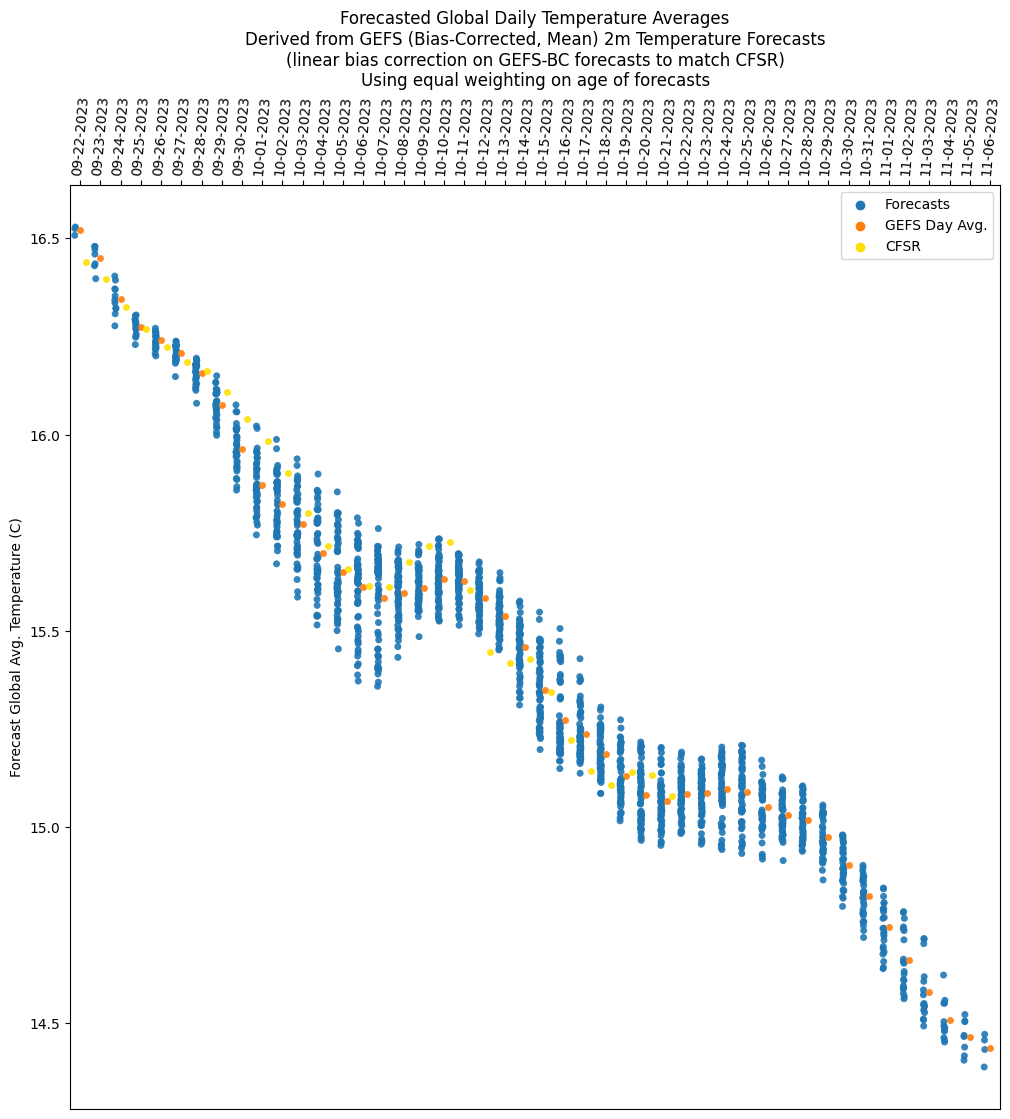

In [219]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 500em; }</style>"))

forecast = {}
# for each valid date, keep track of forecast tau's (in number of hours)
forecast_taus = {}
# exclude forecasts older than this date, or set to None for ALL
#min_forecast_date = "2023-08-19"
min_forecast_date = "2023-09-21"

# overlay cfsr data in observations?
overlay_cfsr = True

# get cfsr data for extrapolate year
cfsr_temps_extrapolate_year = get_cfsr_temps(cfsr_filepath, cfsr_extrapolate_year)    
cfsr_temps_in_forecast_period = {}

for folder_name, complete_average in complete_averages.items():
    # each forecast has a set of forecast dates
    # use if want to prune old forecasts
    short_date = folder_name.split('.')[1].split('_')[0]
    short_date_hour = folder_name.split('.')[1].split('_')[1]

    # Date to compare in the format YYYY-MM-DD
    if min_forecast_date:
        compare_date = datetime.strptime(min_forecast_date, "%Y-%m-%d")
    else:
        compare_date = None
        
    # Convert the short date to a comparable format
    short_date_dt = datetime.strptime(short_date, "%Y%m%d")
    short_date_with_hour_dt = datetime.strptime(f'{short_date} {short_date_hour}', "%Y%m%d %H")
    # Compare the dates
    if not compare_date or compare_date <= short_date_dt:
        for valid_time, forecast_average in complete_average.items():
            day_str = date_to_day_str(valid_time)
            
            if day_str not in forecast:
                forecast[day_str] = []
            temps = forecast[day_str]
            temps.append(forecast_average)
            forecast[day_str] = temps
            
            # convert tau to hours (leave as float)
            tau = (valid_time - short_date_with_hour_dt).total_seconds() / 3600
            if day_str not in forecast_taus:
                forecast_taus[day_str] = []
            taus = forecast_taus[day_str]
            taus.append(tau)
            forecast_taus[day_str] = taus
            #print(tau)
            #print(f"{day_str} : {forecast_average}")
            
            # add the cfsr temps for that date if available
            cfsr_date_str = valid_time.strftime("%Y-%m-%d")
            if cfsr_date_str in cfsr_temps_extrapolate_year:
                cfsr_temps_in_forecast_period[day_str] = cfsr_temps_extrapolate_year[cfsr_date_str]

if overlay_cfsr:
    # bias corrected gefs, overlay cfsr (use cfsr record)
    record = 17.114
    #graph_strip_plot_decay(forecast, record)
    #graph_strip_plot_decay(forecast, record, cfsr_temps_in_forecast_period, bias_correction=False, forecast_taus=forecast_taus, avg_method = 'equal')
    
    graph_strip_plot_decay(forecast, record, cfsr_temps_in_forecast_period, bias_correction=True, forecast_taus=forecast_taus, avg_method = 'equal')
    #graph_strip_plot_decay(forecast, record, cfsr_temps_in_forecast_period, bias_correction=True, forecast_taus=forecast_taus, avg_method = 'exponential')
    #graph_strip_plot_decay(forecast, record, cfsr_temps_in_forecast_period, bias_correction=True, forecast_taus=forecast_taus, avg_method = 'linear')
    # set mu to prioritize close forecasts (taus are in hours, and lowest tau will be 6)
    mu = 6
    # set sigma (some what arbitrarily) to 72 hours
    sigma = 72
    #graph_strip_plot_decay(forecast, record, cfsr_temps_in_forecast_period, bias_correction=True, forecast_taus=forecast_taus, avg_method = 'gaussian', mu=mu, sigma=sigma)
else:    
    # CFSR record was on August 2. GEFS forecast for August 2 on previous day (t=00) was 8.592
    record = 8.592
    graph_strip_plot(forecast, record)

In [220]:













##############################################################################################################
###### EXTEND CFSR WITH TRANSFORMED GEFS->CFSR TEMPS USING HISTORICAL DATA and adjusted 1979-2000 mean) ######
##############################################################################################################





# TODO USE TREND TECHNIQUE FROM SEA ICE VOLUME AND FIND CORRECT VALUE TO ADJUST BY TO MATCH TREND
















In [221]:
# SET THIS TO THE FIRST DAY IN THE CHART ABOVE
#   this is for cases where we want to exclude old forecasts
#   (when changing min_forecast_date, it is usually the day after this date)
temp_pred_start_date_str = '09-22-2023'
# set to year of CFSR for temps to replace extrapolations with (replacing the null values)
extrapolate_year = 2023

data = {}
with open(cfsr_filepath) as file:
    data = json.load(file)

In [222]:
import pandas as pd
def is_leap_year(year):
    return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

def create_temperature_dataframe(data_list):
    ds_list = []
    y_list = []

    for data_dict in data_list:
        # Check if the 'name' is a 4-digit year
        if len(data_dict['name']) == 4 and data_dict['name'].isdigit():
            series_year = int(data_dict['name'])
            # Determine the number of days for the year
            num_days = 366 if is_leap_year(series_year) else 365

            for day, temp in enumerate(data_dict['data'][:num_days], start=1):
                # Create a datetime object for the date
                date = datetime(series_year, 1, 1) + pd.DateOffset(days=day - 1)
                ds_list.append(date)
                y_list.append(temp)

    # Create the DataFrame at the end
    result_df = pd.DataFrame({'ds': ds_list, 'y': y_list})

    # Sort the DataFrame by the 'ds' column
    result_df = result_df.sort_values(by='ds')

    return result_df

In [223]:
# Example usage:
temperature_df = create_temperature_dataframe(data)

In [224]:
cfsr_missing_future_temps = temperature_df.loc[pd.isna(temperature_df['y'])]
#cfsr_temps = temperature_df.dropna(subset=['y'])
cfsr_temps = temperature_df.copy()

In [225]:
from datetime import datetime, date, timedelta
ds_today = get_today_date()

temp_pred_start_day_num = int(day_str_to_date(temp_pred_start_date_str).strftime('%j'))
extrapolate_year_str = str(extrapolate_year)

yesterday_date = get_today_date() - timedelta(days=1)
yesterday_day_num = int(yesterday_date.strftime('%j'))

temp_pred_index_start_from_today = yesterday_day_num - temp_pred_start_day_num + 1
temp_pred_from_today = []
with open('pred_temps.json') as file:
    predData = json.load(file)
    temp_pred_from_today = predData[date_to_day_str(ds_today)][temp_pred_index_start_from_today:]

In [226]:
cfsr_temps_with_gefs = cfsr_temps.copy()

cfsr_temps_with_gefs.loc[cfsr_temps_with_gefs['ds'] == (ds_today + pd.DateOffset(days=0))]
for (x, temp) in enumerate(temp_pred_from_today):
    ds_temp_pred = ds_today + pd.DateOffset(days=x)
    idx = cfsr_temps_with_gefs.loc[cfsr_temps_with_gefs['ds'] == (ds_today + pd.DateOffset(days=x))].index[0]
    # replace values with forecast (they should all be NaN)
    if pd.isna(cfsr_temps_with_gefs.at[idx, 'y']):
        cfsr_temps_with_gefs.at[idx, 'y'] = temp

In [227]:
cfsr_with_gefs_missing_future_temps = cfsr_temps_with_gefs.loc[pd.isna(cfsr_temps_with_gefs['y'])]
cfsr_temps_with_gefs_complete = cfsr_temps_with_gefs.copy().dropna()
cfsr_temps_complete = cfsr_temps.copy().dropna()

In [228]:
# You might need to install fbprophet using "pip install fbprophet" first.
from prophet import Prophet
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly

# copied from my other notebooks so may be irrelevant comments/code

def doForecast(df_historical, period):
    # Step 3: Forecasting with Prophet
    # Create a Prophet model
    model = Prophet(interval_width=0.995, seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    
    # Fit the model to your data
    model.fit(df_historical)

    # Create a DataFrame with future dates for prediction
    future_dates = model.make_future_dataframe(periods=period, include_history=False)  # Forecasting 365 days into the future

    # Make predictions for the future dates
    forecast = model.predict(future_dates)
    return forecast, model

def doForecastWithParams(df_historical, period, changepoint_prior_scale, seasonality_prior_scale, change_dates = None):
    # Step 3: Forecasting with Prophet
    # Create a Prophet model
    model = Prophet(interval_width=0.995, changepoints=change_dates, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    
    # Fit the model to your data
    model.fit(df_historical)

    # Create a DataFrame with future dates for prediction
    future_dates = model.make_future_dataframe(periods=period, include_history=False)  # Forecasting 365 days into the future

    # Make predictions for the future dates
    forecast = model.predict(future_dates)
    return forecast, model

def doForecastCross(df_historical, periods, params, change_dates = None):
    # Step 3: Forecasting with Prophet
    # Create a Prophet model
    # Adjusted hyper-parameter changepoint_prior_scale:
    # initial tuning suggests 0.5, 10 but this only gets the minimum and increases the error farther out for the max
    model = Prophet(interval_width=0.995, changepoints=change_dates, seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, **params)
    
    # Fit the model to your data
    model.fit(df_historical)

    # Create a DataFrame with future dates for prediction
    future_dates = model.make_future_dataframe(periods=period, include_history=False)  # Forecasting 365 days into the future

    # Make predictions for the future dates
    forecast = model.predict(future_dates)
    return forecast, model

In [229]:
# Create a new column 'Year' from the 'ds' column
df_tmp = cfsr_temps_complete.copy()
df_tmp['Year'] = df_tmp['ds'].dt.year

# Set the 'ds' column as the DataFrame index
df_tmp.set_index('ds', inplace=True)
# Group by year and find the minimum and maximum date for each year
min_max_dates = df_tmp.resample('Y')['y'].agg(['idxmin', 'idxmax']).values.flatten()
# Format the dates as "YYYY-MM-DD" strings
min_max_dates = pd.to_datetime(min_max_dates)
min_max_dates = [date.strftime('%Y-%m-%d') for date in min_max_dates]

# Display the list of minimum and maximum dates for each year
print(min_max_dates)

['1979-02-04', '1979-08-08', '1980-01-31', '1980-07-23', '1981-12-31', '1981-08-07', '1982-01-18', '1982-07-20', '1983-12-30', '1983-06-26', '1984-01-31', '1984-08-20', '1985-02-11', '1985-08-04', '1986-01-22', '1986-07-16', '1987-01-03', '1987-07-15', '1988-12-30', '1988-07-18', '1989-01-05', '1989-07-20', '1990-01-14', '1990-07-08', '1991-01-06', '1991-07-31', '1992-12-25', '1992-07-02', '1993-01-10', '1993-07-02', '1994-01-16', '1994-07-27', '1995-12-11', '1995-08-03', '1996-01-19', '1996-08-04', '1997-01-13', '1997-06-22', '1998-01-14', '1998-08-06', '1999-01-11', '1999-07-29', '2000-01-16', '2000-08-01', '2001-02-04', '2001-07-14', '2002-12-26', '2002-07-06', '2003-01-01', '2003-07-20', '2004-01-08', '2004-08-13', '2005-01-23', '2005-07-15', '2006-01-17', '2006-08-03', '2007-12-27', '2007-07-05', '2008-01-21', '2008-07-27', '2009-01-11', '2009-07-21', '2010-12-31', '2010-07-30', '2011-01-23', '2011-07-12', '2012-02-01', '2012-06-30', '2013-01-18', '2013-06-27', '2014-02-06', '2014

In [230]:
# Do forecast for current year, for graph
# Period of days into the future to forecast
# For this graph we will use a whole year into the future to forecast
period = 365

# Without any tuning
#[forecast, model] = doForecast(df_new, period)

# With tuning from cross-validation

cutoff_date_timestamp = cfsr_temps_with_gefs_complete['ds'].iloc[-1]
# May have a min/max from this year that is definitely not the max (i.e. if done before winter/summer), so set and modify from above print if necessary
#min_max_dates = ['1979-02-04', '1979-08-08', '1980-01-31', '1980-07-23', '1981-12-31', '1981-08-07', '1982-01-18', '1982-07-20', '1983-12-30', '1983-06-26', '1984-01-31', '1984-08-20', '1985-02-11', '1985-08-04', '1986-01-22', '1986-07-16', '1987-01-03', '1987-07-15', '1988-12-30', '1988-07-18', '1989-01-05', '1989-07-20', '1990-01-14', '1990-07-08', '1991-01-06', '1991-07-31', '1992-12-25', '1992-07-02', '1993-01-10', '1993-07-02', '1994-01-16', '1994-07-27', '1995-12-11', '1995-08-03', '1996-01-19', '1996-08-04', '1997-01-13', '1997-06-22', '1998-01-14', '1998-08-06', '1999-01-11', '1999-07-29', '2000-01-16', '2000-08-01', '2001-02-04', '2001-07-14', '2002-12-26', '2002-07-06', '2003-01-01', '2003-07-20', '2004-01-08', '2004-08-13', '2005-01-23', '2005-07-15', '2006-01-17', '2006-08-03', '2007-12-27', '2007-07-05', '2008-01-21', '2008-07-27', '2009-01-11', '2009-07-21', '2010-12-31', '2010-07-30', '2011-01-23', '2011-07-12', '2012-02-01', '2012-06-30', '2013-01-18', '2013-06-27', '2014-02-06', '2014-08-03', '2015-01-08', '2015-08-02', '2016-01-19', '2016-08-13', '2017-01-08', '2017-07-28', '2018-01-14', '2018-07-27', '2019-01-10', '2019-08-07', '2020-12-31', '2020-07-11', '2021-01-18', '2021-08-02', '2022-12-24', '2022-07-24', '2023-01-15', '2023-07-06']
# Convert the list of date strings to pandas Timestamp objects
timestamps = pd.to_datetime(min_max_dates)
# Filter the timestamps to include only dates before the cutoff_date
cutoff_change_dates = timestamps[timestamps <= cutoff_date_timestamp]
# Sort the Timestamps in increasing order
cutoff_change_dates = cutoff_change_dates.sort_values()
# Convert the filtered timestamps back to date strings
cutoff_change_dates_strings = cutoff_change_dates.strftime('%Y-%m-%d').tolist()

# hyper-parameter guesses (no validation done for this notebook)
# how tight to keep to the prior values & trend (this is not perfect, there may be discontinuities)
changepoint_prior_scale = 0.01
# regularization (10 is no regularization penalty for seasonality)
seasonality_prior_scale = 10
[forecast, model] = doForecastWithParams(cfsr_temps_with_gefs_complete, period, changepoint_prior_scale, seasonality_prior_scale, cutoff_change_dates_strings)

# Print the forecasted values
print("Forecast DataFrame:")
print(forecast)

20:40:29 - cmdstanpy - INFO - Chain [1] start processing
20:41:27 - cmdstanpy - INFO - Chain [1] done processing


Forecast DataFrame:
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2023-11-07  15.160375   13.965148   14.813839    15.160372    15.160375   
1   2023-11-08  15.161214   13.962952   14.797287    15.161161    15.161272   
2   2023-11-09  15.162052   13.941828   14.745880    15.161907    15.162155   
3   2023-11-10  15.162890   13.873250   14.742485    15.162664    15.163050   
4   2023-11-11  15.163729   13.851298   14.697353    15.163390    15.164051   
..         ...        ...         ...         ...          ...          ...   
360 2024-11-01  15.462159   14.462957   15.348592    15.296983    15.600167   
361 2024-11-02  15.462997   14.370237   15.281257    15.297194    15.601569   
362 2024-11-03  15.463836   14.388287   15.254337    15.297405    15.602970   
363 2024-11-04  15.464674   14.332833   15.247370    15.297615    15.604371   
364 2024-11-05  15.465512   14.243936   15.231337    15.297826    15.605772   

     additive_terms  additive_t

In [231]:
forecast_df = forecast.loc[-365:]
# The DataFrame should contain a 'ds' column with the dates and a 'yhat' column with the forecasted values.

# Convert the 'ds' column to pandas datetime objects (if not already)
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])

do_plot = False
if do_plot:
    # Plot the forecast using plot_plotly
    fig = plot_plotly(model, forecast_df)
    # Set the default range for the x-axis (datetimestamp)
    start_date = pd.to_datetime('2012-01-01')
    end_date = pd.to_datetime('2024-12-31')
    fig.update_xaxes(range=[start_date, end_date])
    fig.update_layout(title_text="World 2m average temp (area-weighted) using adjusted GEFS(+368h) to CFSR historical data)")
    fig.update_yaxes(title_text="Volume (10^6 km^3)")
    fig.show()

    # Plot the forecast components using plot_components_plotly
    fig_comp = plot_components_plotly(model, forecast_df)
    fig_comp.show()

In [232]:

forecasted_values = forecast['yhat']

# adjust forecast from first predicted value and beyond from last obs using 5-day trend, offset from last obs
trend_num_days = 5
five_day_trend = cfsr_temps_with_gefs_complete['y'].iloc[-trend_num_days:]
trend = np.polyfit(range(trend_num_days), five_day_trend,1)[0]

last_obs = cfsr_temps_with_gefs_complete['y'].iloc[-1]
first_forecast = forecasted_values[0]
# what the first forecast value should be from 5 day trend
pred_first_forecast_by_obs = last_obs + trend
# what the difference is from forecast
offset_first_forecast_by_obs = pred_first_forecast_by_obs - first_forecast
print(f"Offset for forecast (using 5 day trend, with forecast offset from last obs.): {offset_first_forecast_by_obs}")

df_forecast_adj = forecast_df.copy()
df_forecast_adj['yhat'] = df_forecast_adj['yhat'] + offset_first_forecast_by_obs

Offset for forecast (using 5 day trend, with forecast offset from last obs.): -0.010079994216633636


In [233]:
import copy

# add the values of df_forecast_adj for rest of year
extrapolate_year_historical_and_gefs_temps = list(cfsr_temps_with_gefs_complete.loc[(cfsr_temps_with_gefs_complete['ds'].dt.year == extrapolate_year)]['y'].values)
extrapolate_year_prophet_temps = list(df_forecast_adj.loc[(df_forecast_adj['ds'].dt.year == extrapolate_year)]['yhat'].values)
if is_leap_year(extrapolate_year):
    add_null_leap_day = []
else:
    add_null_leap_day = [None]

extrapolate_year_temps = []
extrapolate_year_temps.extend(extrapolate_year_historical_and_gefs_temps)
extrapolate_year_temps.extend(extrapolate_year_prophet_temps)
extrapolate_year_temps.extend(add_null_leap_day)

monthly_cfsr_forecast_file_path = '../../monthly-mean-land-ocean-temp/cfsr_world_t2_day_forecast.json'

cfsr_with_forecast = copy.deepcopy(data)
for i in range(len(cfsr_with_forecast)):
    y = cfsr_with_forecast[i]['name']
    if y == '2023':
        cfsr_with_forecast[i]['data'] = extrapolate_year_temps

# overwrite missing days with forecast avg.
with open(monthly_cfsr_forecast_file_path, 'w') as file:
    json.dump(cfsr_with_forecast, file)

print("Stored new CFSR data with forecasts from GEFS and extended with prophet.")

Stored new CFSR data with forecasts from GEFS and extended with prophet.


### 

In [234]:
# Initialize an empty dictionary to store the errors by lead time
valid_error_temps = {}

# Convert the temp_pred_start_date_str to a datetime object
temp_pred_start_date = pd.to_datetime(temp_pred_start_date_str, format='%m-%d-%Y')

# Loop through the keys and values in predData
for date_str, pred_values in predData.items():
    # Convert the date string to a datetime object
    prediction_date = pd.to_datetime(date_str, format='%m-%d-%Y')
    # If the prediction date is before the temp_pred_start_date, skip it
    if prediction_date < temp_pred_start_date:
        continue

    # Calculate the number of days between temp_pred_start_date and prediction_date
    days_to_skip = (prediction_date - temp_pred_start_date).days + 1
    # Find the corresponding observation date (prediction date + lead time + days to skip)
    for lead_time, pred_temp in enumerate(pred_values[days_to_skip:], start=1):
        obs_date = prediction_date + pd.DateOffset(days=lead_time)
        # Find the observed temperature from cfsr_temps
        obs_temp = cfsr_temps[cfsr_temps['ds'] == obs_date]['y'].values[0]
        if math.isnan(obs_temp):
            continue
        # Calculate the error and add it to the corresponding lead time in valid_error_temps
        if str(lead_time) not in valid_error_temps:
            valid_error_temps[str(lead_time)] = []

        valid_error_temps[str(lead_time)].append(pred_temp - obs_temp)



In [235]:
valid_error_temps

{'1': [0.18467072498090253,
  0.07974260602303751,
  0.044183582744411254,
  0.08038546721774154,
  0.12210996297314658,
  0.09553323230738187,
  -0.011901346650475375,
  -0.064282606663852,
  -0.022615213169986603],
 '2': [0.10353299332037125,
  0.06796786583171865,
  0.09657416101927474,
  0.13102845906286298,
  0.11095727735416361,
  0.009146902473709417,
  -0.04817756387897454,
  -0.023077581868294672],
 '3': [0.09565959359249021,
  0.1223504490705043,
  0.14406339899304932,
  0.11959782316760759,
  0.025892684144396938,
  -0.024850202182557624,
  -0.009227718892162784],
 '4': [0.15347532910220885,
  0.1681143580959752,
  0.13572033035962683,
  0.036955380932894855,
  -0.004393898778337402,
  0.012040684159394743],
 '5': [0.20009227467664736,
  0.16229743697814136,
  0.054511379342388366,
  0.011424880976710128,
  0.03034182963705412],
 '6': [0.19735793611208763,
  0.08576754694811406,
  0.03224335930393529,
  0.045951867793936785],
 '7': [0.1243511299164819, 0.06525646090740267, 0

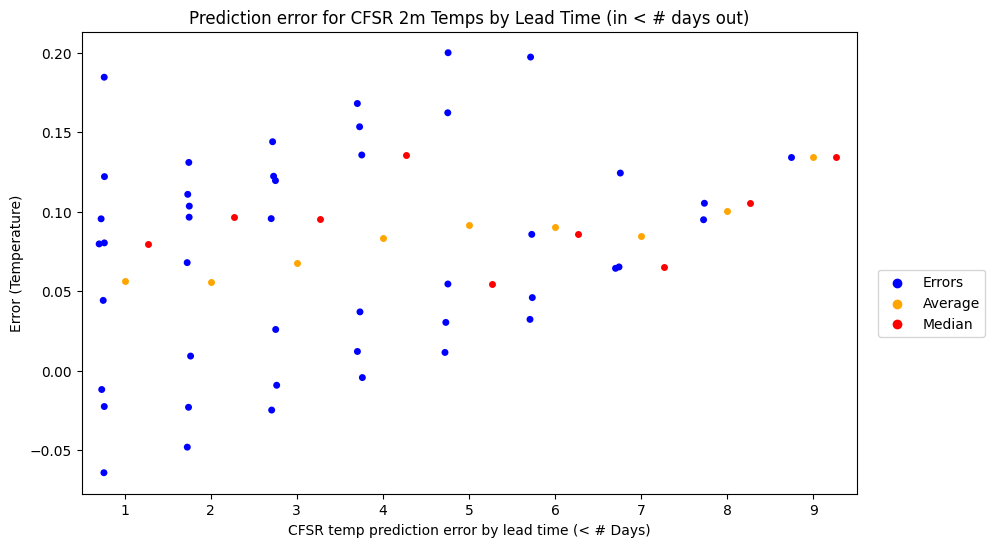

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists for data
lead_times = []
errors = []
data_types = []

# Append data for valid_error_temps, average, and median
for lead, error_values in valid_error_temps.items():
    lead_time = int(lead)
    lead_times.extend([lead_time] * len(error_values))
    errors.extend(error_values)
    data_types.extend(['Errors'] * len(error_values))

    average = sum(error_values) / len(error_values)
    median = sorted(error_values)[len(error_values) // 2]

    lead_times.append(lead_time)
    errors.append(average)
    data_types.append('Average')

    lead_times.append(lead_time)
    errors.append(median)
    data_types.append('Median')

# Create a DataFrame for the data
data = pd.DataFrame({'Lead Time': lead_times, 'Error': errors, 'Data Type': data_types})

# Create a strip plot with Seaborn
plt.figure(figsize=(10, 6))
sns.stripplot(data=data, x='Lead Time', y='Error', dodge=True, hue='Data Type', palette={'Errors': 'blue', 'Average': 'orange', 'Median': 'red'})
plt.xlabel('CFSR temp prediction error by lead time (< # Days)')
plt.ylabel('Error (Temperature)')
plt.title('Prediction error for CFSR 2m Temps by Lead Time (in < # days out)')

# Show the legend
plt.legend(loc='upper right', bbox_to_anchor=(1.175, 0.5))

# Show the plot
plt.show()
